In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import requests
from tqdm.auto import tqdm
from scipy.stats import mode 
from pprint import pprint
from implicit.nearest_neighbours import CosineRecommender
import warnings
warnings.filterwarnings("ignore")

from rectools import Columns

pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 200)

# 🎬 Get KION dataset 

<a href="https://ods.ai/competitions/competition-recsys-21/data"> Dataset description [ru] </a>


In [2]:
# download dataset by chunks
url = "https://storage.yandexcloud.net/itmo-recsys-public-data/kion_train.zip"

req = requests.get(url, stream=True)

with open('kion_train.zip', "wb") as fd:
    total_size_in_bytes = int(req.headers.get('Content-Length', 0))
    progress_bar = tqdm(desc='kion dataset download', total=total_size_in_bytes, unit='iB', unit_scale=True)
    for chunk in req.iter_content(chunk_size=2 ** 20):
        progress_bar.update(len(chunk))
        fd.write(chunk)

In [3]:
!unzip kion_train.zip

# EDA

In [4]:
interactions = pd.read_csv('kion_train/interactions.csv')
users = pd.read_csv('kion_train/users.csv')
items = pd.read_csv('kion_train/items.csv')

In [5]:
# rename columns, convert timestamp
interactions.rename(columns={'last_watch_dt': Columns.Datetime,
                            'total_dur': Columns.Weight}, 
                    inplace=True) 

interactions['datetime'] = pd.to_datetime(interactions['datetime'])

## interactions

In [6]:
pd.concat([interactions.head(), interactions.tail()])

,user_id,item_id,datetime,weight,watched_pct
0,176549,9506,2021-05-11,4250,72.0
1,699317,1659,2021-05-29,8317,100.0
2,656683,7107,2021-05-09,10,0.0
3,864613,7638,2021-07-05,14483,100.0
4,964868,9506,2021-04-30,6725,100.0
5476246,648596,12225,2021-08-13,76,0.0
5476247,546862,9673,2021-04-13,2308,49.0
5476248,697262,15297,2021-08-20,18307,63.0
5476249,384202,16197,2021-04-19,6203,100.0
5476250,319709,4436,2021-08-15,3921,45.0


In [7]:
print(f"Interactions dataframe shape: {interactions.shape}")
print(f"Unique users in interactions: {interactions['user_id'].nunique():_}")
print(f"Unique items in interactions: {interactions['item_id'].nunique():_}")

Interactions dataframe shape: (5476251, 5)
Unique users in interactions: 962_179
Unique items in interactions: 15_706


In [8]:
max_date = interactions['datetime'].max()
min_date = interactions['datetime'].min()

print(f"min date in interactions: {min_date}")
print(f"max date in interactions: {max_date}")

min date in interactions: 2021-03-13 00:00:00
max date in interactions: 2021-08-22 00:00:00


In [9]:
interactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5476251 entries, 0 to 5476250
Data columns (total 5 columns):
 #   Column       Dtype         
---  ------       -----         
 0   user_id      int64         
 1   item_id      int64         
 2   datetime     datetime64[ns]
 3   weight       int64         
 4   watched_pct  float64       
dtypes: datetime64[ns](1), float64(1), int64(3)
memory usage: 208.9 MB


## users

In [10]:
pd.concat([users.head(), users.tail()])

,user_id,age,income,sex,kids_flg
0,973171,age_25_34,income_60_90,М,1
1,962099,age_18_24,income_20_40,М,0
2,1047345,age_45_54,income_40_60,Ж,0
3,721985,age_45_54,income_20_40,Ж,0
4,704055,age_35_44,income_60_90,Ж,0
840192,339025,age_65_inf,income_0_20,Ж,0
840193,983617,age_18_24,income_20_40,Ж,1
840194,251008,NaN,NaN,NaN,0
840195,590706,NaN,NaN,Ж,0
840196,166555,age_65_inf,income_20_40,Ж,0


In [11]:
print(f"Users dataframe shape {users.shape}")
print(f"Unique users: {users['user_id'].nunique():_}")

Users dataframe shape (840197, 5)
Unique users: 840_197


## items

In [12]:
pd.concat([items.head(3), items.tail(3)])

,item_id,content_type,title,title_orig,release_year,genres,countries,for_kids,age_rating,studios,directors,actors,description,keywords
0,10711,film,Поговори с ней,Hable con ella,2002.0,"драмы, зарубежные, детективы, мелодрамы",Испания,NaN,16.0,NaN,Педро Альмодовар,"Адольфо Фернандес, Ана Фернандес, Дарио Грандинетти, Джеральдин Чаплин, Елена Анайя, Каэтано Велозо, Леонор Уотлинг, Лола Дуэньяс, Лолес Леон, Малу Айродо, Мариола Фуэнтес, Пас Вега, Пина Бауш, Ро...",Мелодрама легендарного Педро Альмодовара «Поговори с ней» в 2003 году получила премию «Оскар» за лучший сценарий. Журналист Марко берет интервью у знаменитой женщины-тореро Лидии и вскоре влюбляе...,"Поговори, ней, 2002, Испания, друзья, любовь, сильные, женщины, преодоление, трудностей, отношения, дружба, отношения, паре, отношения, мужчины, женщины, романтические, отношения, потеря, близких,..."
1,2508,film,Голые перцы,Search Party,2014.0,"зарубежные, приключения, комедии",США,NaN,16.0,NaN,Скот Армстронг,"Адам Палли, Брайан Хаски, Дж.Б. Смув, Джейсон Манцукас, Джон Глейсер, Карл Грин, Кристен Риттер, Лэнс Реддик, Морис Комт, Патрик Кернс, Ребекка Коллинз, Роза Салазар, Росс П. Кук, Стеффи Гроут, Ти...","Уморительная современная комедия на популярную тему о том, как не надо отмечать мальчишник. Главный герой усвоил, что не надо звать на свадьбу своего друга Джейсона, из-за которого он вместо сваде...","Голые, перцы, 2014, США, друзья, свадьбы, преодоление, трудностей, расставания, отношения, дружба, риск, недоразумение, мужская, дружба, мальчишники, девичники"
2,10716,film,Тактическая сила,Tactical Force,2011.0,"криминал, зарубежные, триллеры, боевики, комедии",Канада,NaN,16.0,NaN,Адам П. Калтраро,"Адриан Холмс, Даррен Шалави, Джерри Вассерман, Дэн Риззуто, Кендес Илэйн Калтраро, Кит Джардин, Лекса Дойг, Майкл Джей Уайт, Майкл Шэнкс, Майкл Эклунд, Питер Брайант, Питер Кент, Стив Бачич, Стив ...","Профессиональный рестлер Стив Остин («Все или ничего») и темнокожий мачо Майкл Джей Уайт («Темный рыцарь») в интригующем криминальном боевике. В центре сюжета – команда спецназовцев, которая оказа...","Тактическая, сила, 2011, Канада, бандиты, гангстеры, преступления, преодоление, трудностей, убийства, убийцы, настоящие, мужчины, риск, недоразумение, силы, правопорядка, борьба, за, выживание, сп..."
15960,10632,series,Сговор,Hassel,2017.0,"драмы, триллеры, криминал",Россия,0.0,18.0,NaN,"Эшреф Рейбрук, Амир Камдин, Эрик Эгер","Ола Рапас, Алиетт Офейм, Уильма Лиден, Шанти Рони, Тома Холмин","Криминальная драма по мотивам романов о шведском детективе Роланде Хасселе. Средь бела дня убит полицейский, и нити в этом деле ведут прямо в коридоры власти. Расследованием занимается детектив Ха...","Сговор, 2017, Россия"
15961,4538,series,Среди камней,Darklands,2019.0,"драмы, спорт, криминал",Россия,0.0,18.0,NaN,"Марк О’Коннор, Конор МакМахон","Дэйн Уайт О’Хара, Томас Кэйн-Бирн, Джудит Родди, Марк О’Халлоран, Джимми Смоллхорн","Семнадцатилетний Дэмиен мечтает вырваться за пределы своего района и стать профессиональным бойцом. Когда его кумир и старший брат исчезает, парень попадает в чуждый ему мир насилия, наркотиков и ...","Среди, камней, 2019, Россия"
15962,3206,series,Гоша,NaN,2019.0,комедии,Россия,0.0,16.0,NaN,Михаил Миронов,"Мкртыч Арзуманян, Виктория Рунцова","Добродушный Гоша не может выйти из дома, чтобы не попасть в нелепую и курьёзную историю. Но даже неудачники мечтают о любви, и наш герой — не исключение, ведь оптимизма ему не занимать.","Гоша, 2019, Россия"


In [13]:
print(f"Items dataframe shape {items.shape}")
print(f"Unique item_id: {items['item_id'].nunique():_}")

Items dataframe shape (15963, 14)
Unique item_id: 15_963


# 🧩 New model: from `itemkNN` to `userkNN `

- we'll use `implicit.nearest_neighbours` itemKNN model and convert it to userkNN model 


## 0. train test split 

In [14]:
# train test split 
# test = last 1 week 
from rectools.model_selection import TimeRangeSplit

n_folds = 1
unit = "W"
n_units = 1
periods = n_folds + 1
freq = f"{n_units}{unit}"

last_date = interactions[Columns.Datetime].max().normalize()
start_date = last_date - pd.Timedelta(n_folds * n_units + 1, unit=unit)  
print(f"Start date and last date of the test fold: {start_date, last_date}")
    
date_range = pd.date_range(start=start_date, periods=periods, freq=freq, tz=last_date.tz)
print(f"Test fold borders: {date_range.values.astype('datetime64[D]')}")

# generator of folds
cv = TimeRangeSplit(
    date_range=date_range,
    filter_already_seen=True,
    filter_cold_items=True,
    filter_cold_users=True,
)
print(f"Real number of folds: {cv.get_n_splits(interactions)}")

Start date and last date of the test fold: (Timestamp('2021-08-08 00:00:00'), Timestamp('2021-08-22 00:00:00'))
Test fold borders: ['2021-08-08' '2021-08-15']
Real number of folds: 1


In [15]:
# we have just 1 test fold - no need to iterate over fold
(train_ids, test_ids, fold_info) = cv.split(interactions, collect_fold_stats=True).__next__()

In [16]:
train_ids

array([      0,       1,       2, ..., 5476245, 5476247, 5476249])

In [17]:
test_ids

array([      6,      33,      56, ..., 5476229, 5476230, 5476240])

# 1. Prepare train matrix 

### 1.1 Create `user` and `item` mappings (essential part for recsys models) 

users_mapping = `{user0: 0, user1: 1, ... , userN: N}`

items_mapping = `{item0: 0, item1: 1, ... , itemK: K}`

In [18]:
train = interactions.loc[train_ids]
test = interactions.loc[test_ids]

In [19]:
users_inv_mapping = dict(enumerate(train['user_id'].unique()))
users_mapping = {v: k for k, v in users_inv_mapping.items()}

In [20]:
items_inv_mapping = dict(enumerate(train['item_id'].unique()))
items_mapping = {v: k for k, v in items_inv_mapping.items()}

In [21]:
print(f"users_mapping amount: {len(users_mapping)}")
print(f"items_mapping amount: {len(items_mapping)}")

users_mapping amount: 842129
items_mapping amount: 15404


### 2.2 Get sparse matrix 

In [22]:
def get_coo_matrix(df, 
                   user_col='user_id', 
                   item_col='item_id', 
                   weight_col=None, 
                   users_mapping=None, 
                   items_mapping=None):
    if weight_col:
        weights = df[weight_col].astype(np.float32)
    else:
        weights = np.ones(len(df), dtype=np.float32)

    interaction_matrix = sp.sparse.coo_matrix((
        weights, 
        (
            df[user_col].map(users_mapping.get), 
            df[item_col].map(items_mapping.get)
        )
    ))
    return interaction_matrix

In [23]:
interaction_matrix = get_coo_matrix(train, weight_col='weight',
                                    users_mapping=users_mapping, 
                                    items_mapping=items_mapping)

In [24]:
interaction_matrix

<842129x15404 sparse matrix of type '<class 'numpy.float32'>'
	with 4587708 stored elements in COOrdinate format>

## 2. Fit simple ItemKNN model 

### `userknn disclaimer`:

implicit ItemItemRecommender requires `item-user matrix` (not `user-item` !) => ususally you call fit with transposed weights matrix `model.fit(matrix.T)`. That's how you get item's nearest neighbours. 

but for `the userknn model` we want to have **user** neighbours (not item neighbours). that's why we need to call fit **without transpose**: `model.fit(matrix)`

https://github.com/benfred/implicit/blob/main/implicit/nearest_neighbours.py

In [ ]:
userknn = CosineRecommender(K=30)
userknn.fit(interaction_matrix)

In [ ]:
# save model
import dill

with open('userknn.dill', 'wb') as f:
    dill.dump(userknn, f)

In [27]:
with open('userknn.dill', 'rb') as f:
    userknn = dill.load(f)

In [28]:
userknn.similar_items(1)

[(1, 1.0000000098018893),
 (773911, 0.36543191174204726),
 (115615, 0.3610291122122819),
 (422766, 0.3590583883643988),
 (46469, 0.35822138476497434),
 (338851, 0.3544897034750306),
 (733896, 0.35448970121073087),
 (575, 0.35448970086392395),
 (38208, 0.35448970086392395),
 (289064, 0.35448970086392395)]

## 3. Recommend to get user neighbours

In [29]:
def generate_implicit_recs_mapper(model, N, users_mapping, users_inv_mapping):
    def _recs_mapper(user):
        user_id = users_mapping[user]
        recs = model.similar_items(user_id, N=N)
        return [users_inv_mapping[user] for user, _ in recs], [sim for _, sim in recs]
    return _recs_mapper

In [30]:
mapper = generate_implicit_recs_mapper(
    userknn, 
    N=30,
    users_mapping=users_mapping,
    users_inv_mapping=users_inv_mapping
)

In [31]:
recs = pd.DataFrame({
    'user_id': test['user_id'].unique()
})

recs['similar_user_id'], recs['similarity'] = zip(*recs['user_id'].map(mapper))
recs.head()

,user_id,similar_user_id,similarity
0,1016458,"[1016458, 416417, 859673, 494256, 414523, 254272, 101745, 50573, 55914, 589357, 979361, 742779, 207723, 313525, 911195, 85581, 290121, 797403, 141043, 852836, 820008, 442744, 644153, 545951, 30646...","[1.0000000098027124, 0.6143665279318272, 0.6115098337111928, 0.6031119652865972, 0.6016035410642744, 0.5956601420097666, 0.5951893645435953, 0.5910982730574769, 0.5901959801548787, 0.5899352526319..."
1,68478,"[68478, 20161, 412019, 620526, 695810, 879494, 589849, 988152, 691867, 594451, 871777, 739170, 675522, 543247, 267635, 206217, 737870, 193350, 194019, 458371, 667204, 859502, 81277, 670738, 106863...","[0.9999999999999997, 0.7739892962350301, 0.7739892916809104, 0.7739892904471841, 0.7739892904471841, 0.7739728844372993, 0.773732938463484, 0.7731990156224964, 0.764299456592446, 0.737170322866436..."
2,580093,"[580093, 937473, 86046, 262791, 522603, 521456, 515818, 654291, 1009888, 333513, 788102, 485193, 212614, 328346, 789077, 541830, 530175, 564927, 964340, 555363, 496146, 684866, 674955, 227906, 210...","[0.999999972768243, 0.98170707253408, 0.9816027812180024, 0.9811408740629928, 0.9809446394117618, 0.9804554967089238, 0.9787225812866681, 0.9780463490829185, 0.9761219827587835, 0.9753862067490225..."
3,1072552,"[1072552, 1022231, 449057, 639316, 38521, 992547, 401940, 613583, 184399, 33572, 570020, 739950, 49193, 246357, 162216, 717003, 111832, 896269, 941748, 932452, 414423, 205014, 815335, 140176, 9559...","[1.0000000074842705, 0.48938543442887494, 0.4845394132067774, 0.4778556198287305, 0.4747312631328243, 0.463755730200894, 0.46303331823589533, 0.4624616814044821, 0.46080084719982534, 0.45879293725..."
4,910002,"[910002, 490989, 57211, 914293, 442802, 185148, 594268, 737639, 57072, 55347, 487771, 239022, 1050759, 733214, 235654, 59204, 184097, 489476, 64894, 188880, 588396, 524284, 768525, 15107, 769145, ...","[1.000000020041603, 0.7295340991209922, 0.7236776448102081, 0.7230887217258574, 0.722400619894437, 0.7218159408211805, 0.7216246604867983, 0.7181317479407374, 0.7177606301330373, 0.717526379997592..."


In [32]:
# explode lists to get vertical representation
recs = recs.set_index('user_id').apply(pd.Series.explode).reset_index()

In [33]:
recs.head(30 + 5)

,user_id,similar_user_id,similarity
0,1016458,1016458,1.0
1,1016458,416417,0.614367
2,1016458,859673,0.61151
3,1016458,494256,0.603112
4,1016458,414523,0.601604
5,1016458,254272,0.59566
6,1016458,101745,0.595189
7,1016458,50573,0.591098
8,1016458,55914,0.590196
9,1016458,589357,0.589935


In [34]:
# delete recommendations of itself 
recs = recs[~(recs['similarity'] >= 1)]

In [35]:
recs.shape

(2593099, 3)

In [36]:
recs.head()

,user_id,similar_user_id,similarity
1,1016458,416417,0.614367
2,1016458,859673,0.61151
3,1016458,494256,0.603112
4,1016458,414523,0.601604
5,1016458,254272,0.59566


## 4. Join watched items of neighbour users to get item recommendations

In [37]:
watched = train.groupby('user_id').agg({'item_id': list})
watched.head()

,item_id
user_id,
0,"[7102, 14359, 15297, 6006, 9728, 12192]"
2,"[7571, 3541, 15266, 13867, 12841, 10770, 4475, 9506, 8936, 11018, 11577, 561, 7106, 6774, 16029, 8482, 6825, 3594, 16166, 5819, 2954, 383, 11689, 12449, 2025, 6155, 3628, 334, 4024, 7210, 11539, 1..."
3,"[9728, 16406, 10440, 3475, 4151, 1418, 2220, 3734, 13789, 8581, 13849, 9550, 10464, 4880, 4436, 8801, 11790, 2657, 8252]"
4,"[4700, 6317]"
5,"[14397, 6445, 11437, 5651, 6167, 12466, 632, 8450, 2685, 7825, 3145, 7043, 4179, 15890, 5115, 4719, 10848]"


In [38]:
# join watched items
recs = recs.merge(watched, left_on=['similar_user_id'], right_on=['user_id'], how='left')
recs = recs.explode('item_id')

In [39]:
recs.head()

,user_id,similar_user_id,similarity,item_id
0,1016458,416417,0.614367,11138
0,1016458,416417,0.614367,10464
0,1016458,416417,0.614367,5287
0,1016458,416417,0.614367,14961
0,1016458,416417,0.614367,7448


In [40]:
# drop duplicates pairs user_id-item_id 
# keep with the largest similiarity
recs = recs.sort_values(['user_id', 'similarity'], ascending=False)
recs.head()

,user_id,similar_user_id,similarity,item_id
2438492,1097544,412291,0.704641,8636
2438492,1097544,412291,0.704641,7829
2438492,1097544,412291,0.704641,9996
2438493,1097544,426470,0.704458,7829
2438494,1097544,735025,0.704458,7829


In [41]:
recs = recs.drop_duplicates(['user_id', 'item_id'], keep='first')

In [42]:
recs.shape

(4887448, 4)

## 5. Make `rank` from similarity



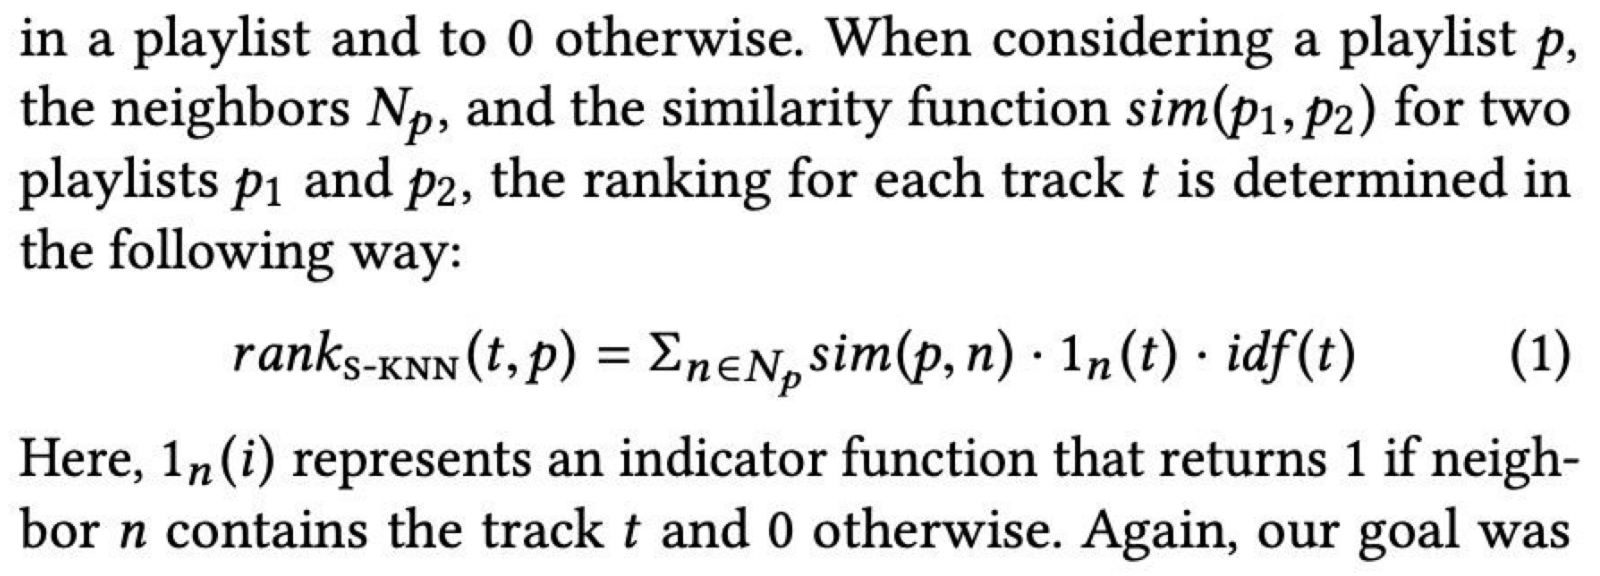



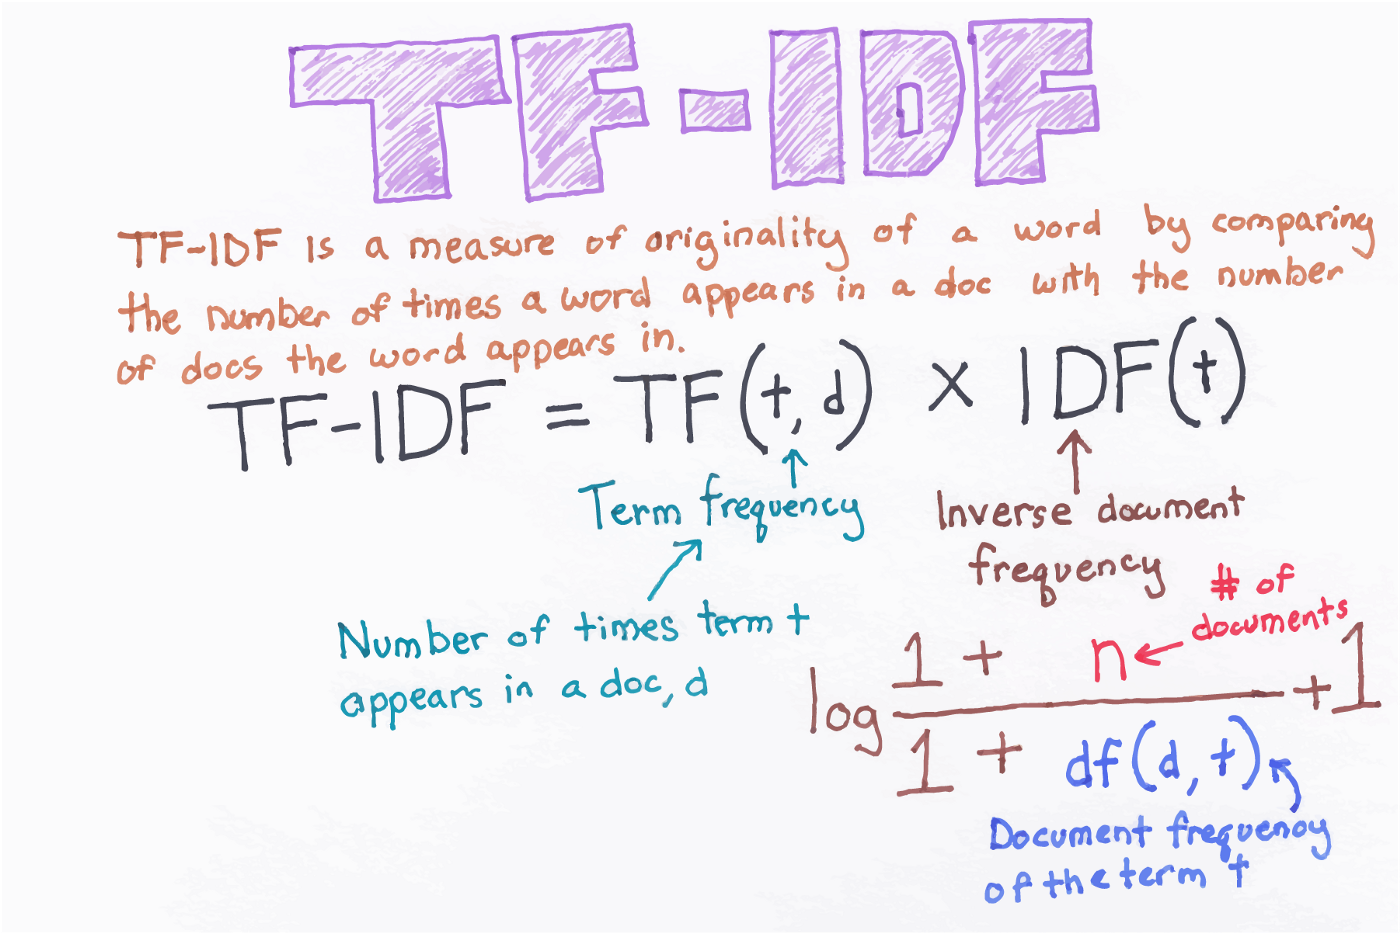

### 5.1 `idf` for each item

`document frequency (= recommendation list frequency) of the item` in this case is just a count of item in dataframe (because item can appear only no more than once in a recommended list)


In [43]:
from collections import Counter
cnt = Counter(train['item_id'].values)

In [44]:
# convert counter to dataframe
idf = pd.DataFrame.from_dict(cnt, orient='index', columns=['doc_freq']).reset_index()
idf.head()

,index,doc_freq
0,9506,3407
1,1659,891
2,7107,16279
3,7638,1067
4,6686,1529


In [45]:
# num of documents = num of recommendation list = dataframe shape
n = train.shape[0]
idf['idf'] = idf['doc_freq'].apply(lambda x: np.log((1 + n) / (1 + x) + 1))

- `idf` is greater for `non-popular` items 
- in the one user recommendation all similarities are the same

=> we highlight less popular items in the user recommendation

In [46]:
idf.head()

,index,doc_freq,idf
0,9506,3407,7.205753
1,1659,891,8.545620
2,7107,16279,5.644741
3,7638,1067,8.365581
4,6686,1529,8.006202


In [47]:
# join idf 
recs = recs\
    .merge(
        idf[['index', 'idf']], 
        left_on='item_id',
        right_on='index',
        how='left')\
    .drop(['index'], axis=1)

recs.head()

,user_id,similar_user_id,similarity,item_id,idf
0,1097544,412291,0.704641,8636,4.958912
1,1097544,412291,0.704641,7829,5.770857
2,1097544,412291,0.704641,9996,4.928260
3,1097534,1097534,1.0,9996,4.928260
4,1097534,1097534,1.0,9728,3.792339


In [48]:
recs['rank_idf'] = recs['similarity'] * recs['idf']

In [49]:
recs.head()

,user_id,similar_user_id,similarity,item_id,idf,rank_idf
0,1097544,412291,0.704641,8636,4.958912,3.494255
1,1097544,412291,0.704641,7829,5.770857,4.066384
2,1097544,412291,0.704641,9996,4.928260,3.472656
3,1097534,1097534,1.0,9996,4.928260,4.92826
4,1097534,1097534,1.0,9728,3.792339,3.792339


In [50]:
# make order by rank_idf 
recs = recs.sort_values(['user_id', 'rank_idf'], ascending=False)

In [51]:
# make rank
recs['rank'] = recs.groupby('user_id').cumcount() + 1 

In [52]:
recs.head()

,user_id,similar_user_id,similarity,item_id,idf,rank_idf,rank
1,1097544,412291,0.704641,7829,5.770857,4.066384,1
0,1097544,412291,0.704641,8636,4.958912,3.494255,2
2,1097544,412291,0.704641,9996,4.928260,3.472656,3
92,1097534,680867,0.919573,995,11.048448,10.15985,1
19,1097534,1081871,0.942736,8586,9.870883,9.305635,2


## 6. Metrics

In [53]:
from rectools.metrics import Precision, Recall, MeanInvUserFreq, Serendipity, calc_metrics

# calculate several classic (precision@k and recall@k) and "beyond accuracy" metrics
metrics = {
    "prec@10": Precision(k=10),
    "recall@10": Recall(k=10),
    "novelty": MeanInvUserFreq(k=10),
    "serendipity": Serendipity(k=10),
}

catalog = train['item_id'].unique()
    
metric_values = calc_metrics(
            metrics,
            reco=recs,
            interactions=test,
            prev_interactions=train,
            catalog=catalog
        )

In [54]:
metric_values

{'prec@10': 0.0020689722796936746,
 'recall@10': 0.009460160471322412,
 'novelty': 10.191797483381356,
 'serendipity': 6.499134741537922e-05}

## 7. Issues to solve

In [55]:
# number of recommendations per user < N
recs['rank'].value_counts()

1       89372
2       83884
3       81210
4       79298
5       77663
        ...  
2242        1
2243        1
2244        1
2245        1
2397        1
Name: rank, Length: 2397, dtype: int64

## 8. Compare with ItemKnn

In [56]:
from rectools.dataset import Dataset

dataset = Dataset.construct(
    interactions_df=train,
    user_features_df=None,
    item_features_df=None
)

In [57]:
from implicit.nearest_neighbours import CosineRecommender
# ImplicitItemKNNWrapperModel - wrapper on implicit.nearest_neighbours.ItemItemRecommender
from rectools.models.implicit_knn import ImplicitItemKNNWrapperModel

item_knn = ImplicitItemKNNWrapperModel(model=CosineRecommender(K=30))
item_knn.fit(dataset);

In [58]:
# take a look at the recommended items by the simple itemknn model
recs_itemknn = item_knn.recommend(
    test['user_id'].unique(), 
    dataset=dataset, 
    k=10, 
    filter_viewed=False  # False - same items to every user
)

In [59]:
recs_itemknn.head()

,user_id,item_id,score,rank
0,1016458,10440,20431.631150,1
1,1016458,734,8043.999962,2
2,1016458,12192,8033.599530,3
3,1016458,1986,7999.805731,4
4,1016458,4457,7763.204607,5


In [60]:
metric_values_itemknn = calc_metrics(
            metrics,
            reco=recs_itemknn,
            interactions=test,
            prev_interactions=train,
            catalog=catalog
        )

In [61]:
metric_values_itemknn

{'prec@10': 0.017311708814214132,
 'recall@10': 0.09520897568691472,
 'novelty': 8.053184749097186,
 'serendipity': 6.63288816067437e-05}